In [1]:
using CairoMakie, Dierckx, Optim, LinearAlgebra, QuantEcon

In [2]:
set_theme!(theme_dark())

In [133]:
function create_EGM_model(;nk = 101, nz = 19)

    p = (;α = 0.33, # Capital share
    β = 0.96, # Discount factor
    A = 0.5, # TFP
    γ = 1.0, # Risk aversion
    δ = 1.0, # Depreciation rate
    nk = nk, # Number of capital gridpoints
    nz = nz, # Number of shock gridpoints
    θ = 2, # Grid expansion parameter
    lb = 10^-4, # Lower bound of capital grid
    ub = 500.0, # Upper bound of capital grid
    ρ = 0.98, # Persistence of AR(1) process
    μ = 0.5, # Mean of AR(1) process
    σ = 0.01, # Var of AR(1) process
    toler = 1e-6, # Tolerance
    maxiter = 500, # Maximum number of iterations
    print_skip = 5, # Print every x iterations
    kgrid = LinRange(0.0,1.0,nk), # Capital grid
    zgrid = LinRange(0.0,1.0,nz), # Shock grid
    Π = zeros(Float64, nz, nz)) # Transition matrix

    # Create productivity grid and transition matrix
    mc = rouwenhorst(p.nz, p.μ, p.ρ, p.σ)
    zgrid, Π = exp.(mc.state_values), mc.p

    # Create capital grid
    temp_grid = LinRange(0.0,1.0,p.nk)
    kgrid = p.lb .+ (p.ub - p.lb) * (temp_grid .^ p.θ)

    # Return NamedTuple
    p = (p..., kgrid = kgrid, zgrid = zgrid, Π = Π)

    return p
end

model_EGM = create_EGM_model(nk = 101, nz = 19)

(α = 0.33, β = 0.96, A = 0.5, γ = 1.0, δ = 1.0, nk = 101, nz = 19, θ = 2, lb = 0.0001, ub = 500.0, ρ = 0.98, μ = 0.5, σ = 0.01, toler = 1.0e-6, maxiter = 500, print_skip = 5, kgrid = [0.0001, 0.05009999000000001, 0.20009996000000002, 0.45009991, 0.8000998400000001, 1.2500997500000004, 1.80009964, 2.4500995100000007, 3.2000993600000007, 4.05009919  …  414.05001719, 423.20001536, 432.4500135100001, 441.80001164, 451.25000975, 460.80000784, 470.45000590999996, 480.20000395999995, 490.05000199, 500.0], zgrid = [0.008387608038651633, 0.014299146011397482, 0.024377101995354325, 0.041557943475662926, 0.07084774335585627, 0.12078082597029194, 0.20590645842864538, 0.35102814773808405, 0.5984307701894207, 1.0202013400267553, 1.7392333851131028, 2.9650350859298533, 5.054774785284692, 8.617351022656463, 14.690810531036542, 25.044809418971962, 42.696247256574644, 72.78831710388745, 124.0891049505581], Π = [0.005637710113660432 0.033826260681962594 … 7.8580342233181e-10 1.4551915228366852e-11; 0.001

In [134]:
function utility(c)
    if model_EGM.γ == 1.0
        return log(c)
    else
        return (c^(1-model_EGM.γ)-1) / (1-model_EGM.γ)
    end
end 

function marginal_utility(c)
    return c^(-model_EGM.γ)
end

function inverse_marginal_utility(u)
    return u^(-1/model_EGM.γ)
end

function resources(i ,j , p)
    (; α, δ, A, kgrid, zgrid) = p
    return (A * zgrid[j] * (kgrid[i] ^ α)) + (1.0 - δ) * kgrid[i]
end

function marginal_prod(i ,j , p)
    (; α, δ, A, kgrid, zgrid) = p
    return α * A * zgrid[j] * (kgrid[i] ^ (α - 1)) + (1.0 - δ)
end

function initial_guess(p)
    (; nk, nz) = p
    c_pol = zeros(nk, nz)
    for i in 1:nk
        for j in 1:nz
            c_pol[i,j] = 1/2 * resources(i, j, p)
        end
    end
    return c_pol
end

function resource_grid(p)
    (; nk, nz) = p
    Ygrid = zeros(nk, nz)
    for i in 1:nk
        for j in 1:nz
            Ygrid[i,j] = resources(i, j, p)
        end
    end
    return Ygrid
end

function marginal_prod_grid(p)
    (; nk, nz) = p
    MPgrid = zeros(nk, nz)
    for i in 1:nk
        for j in 1:nz
            MPgrid[i,j] = marginal_prod(i, j, p)
        end
    end
    return MPgrid
end

marginal_prod_grid (generic function with 1 method)

In [135]:
function egm(p)
    # Unpack parameters
    (; print_skip, toler, maxiter, Π, kgrid, zgrid, nk, nz, β, A, α, δ, lb, ub) = p

    # Initialise matrices
    c_pol_1 = initial_guess(p)
    c_pol_2 = zeros(nk, nz)
    s_pol = zeros(nk, nz)
    g = zeros(nk, nz)
    V1 = zeros(nk, nz)
    V2 = zeros(nk, nz)
    V3 = zeros(nk, nz)
    V4 = zeros(nk, nz)
    v_out = zeros(nk, nz)
    MPgrid = marginal_prod_grid(p)
    Ygrid = resource_grid(p)

    # Create Spline dictionary
    splines = Dict{Int, Spline1D}()

    # Set error and iteration counter
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end

    while error >= toler && iter <= maxiter
        MUgrid = marginal_utility.(c_pol_1)
        V1 = β .* MUgrid .* MPgrid
        V2 = (Π * V1')'
        V3 = inverse_marginal_utility.(V2)
        V4 = kgrid .+ V3
        if δ == 1.0
            for j in 1:nz
                g[:,j] = (V4[:,j]./(A*zgrid[j])).^(1/α)
            end
        else
            for j in 1:nz
                for i in 1:nk
                    obj(k) = A * zgrid[j] * (k ^ α) + (1.0 - δ) * k - V4[i,j]
                    opt = optimize(obj, lb, ub)
                    g[i,j] = opt.minimizer
                end
            end
        end
        for j in 1:nz
            splines[j] = Spline1D(g[:,j], kgrid, k = 1, bc="extrapolate")
            s_pol[:,j] = splines[j].(kgrid)
        end
        c_pol_2 = Ygrid .- s_pol
        error = maximum(abs.(c_pol_2 - c_pol_1)/(1 .+ abs.(c_pol_1)))
        c_pol_1 = copy(c_pol_2)
        if iter % print_skip == 0
            println("------------------------------------")
            println("Error at iteration $iter is $error")
        end
        iter += 1
    end
    if iter == maxiter
        println("------------------------------------")
        println("Failed to converge after $maxiter iterations")
    else
        println("------------------------------------")
        println("Converged after $iter iterations")
        println("------------------------------------")
    end
    return g, s_pol, c_pol_1
end

test_g, test_s_pol, test_c_pol_1 = egm(model_EGM)

function vals(consumption, p)
    (; nk, nz, β, toler, maxiter, Π, print_skip) = p
    v1 = zeros(nk,nz)
    v2 = zeros(nk,nz)
    iter = 0
    error = toler + 1
    if iter == 0
        println("Iterating...")
    end
    while error >= toler && iter <= maxiter
        v2 = utility.(consumption) + β * v1 * Π'
        error = maximum(abs.(v2 - v1)/(1 .+ abs.(v1)))
        v1 = copy(v2)
        if iter % print_skip == 0
            println("------------------------------------")
            println("Error at iteration $iter is $error")
        end
        iter += 1
    end
    return v1
end

test_vals = vals(test_c_pol_1, model_EGM)

101×19 Matrix{Float64}:
 -103.714   -102.326   -101.131   …  -87.1333   -86.1846   -85.2107
  -54.9357   -53.9064   -52.8929     -39.4139   -38.4161   -37.4208
  -44.2758   -43.2635   -42.2627     -28.7601   -27.7606   -26.7592
  -37.8954   -36.8897   -35.8935     -22.3718   -21.3668   -20.3623
  -33.3976   -32.3961   -31.4028     -17.8628   -16.8552   -15.8507
  -30.0869   -29.0895   -28.0993  …  -14.5298   -13.5213   -12.5137
  -27.0756   -26.079    -25.0891     -11.501    -10.4949    -9.48687
  -24.7025   -23.7076   -22.7189      -9.12495   -8.11816   -7.1096
  -22.5716   -21.5776   -20.5892      -6.98921   -5.98123   -4.97221
  -20.7133   -19.7201   -18.732       -5.12297   -4.11627   -3.10615
    ⋮                             ⋱                        
   16.3141    17.3019    18.2694      32.1008    33.1167    34.1342
   16.4923    17.48      18.4471      32.2792    33.2949    34.3125
   16.6678    17.6554    18.6221      32.4549    33.4707    34.4881
   16.8411    17.8286    18.7

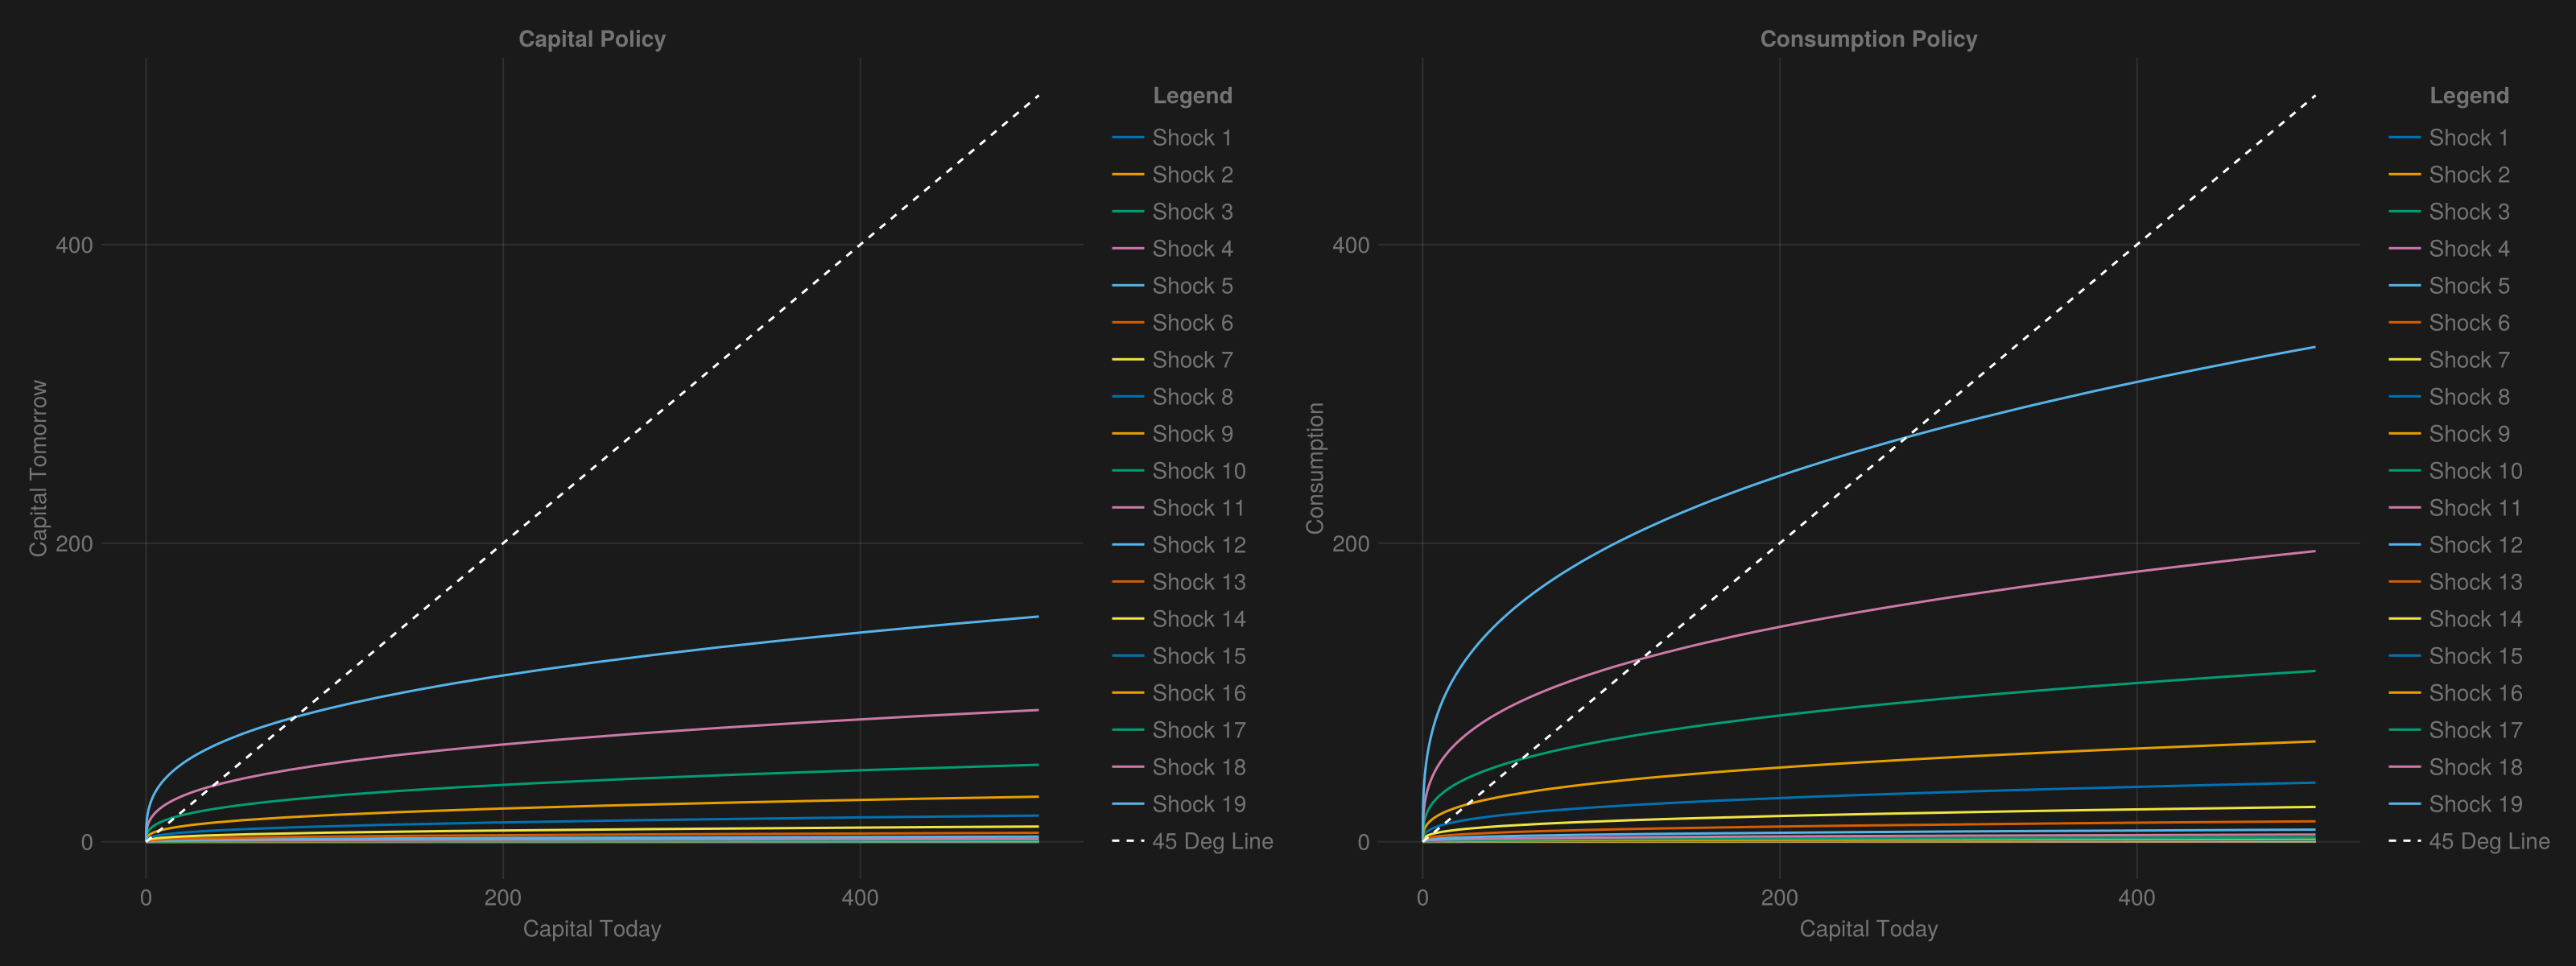

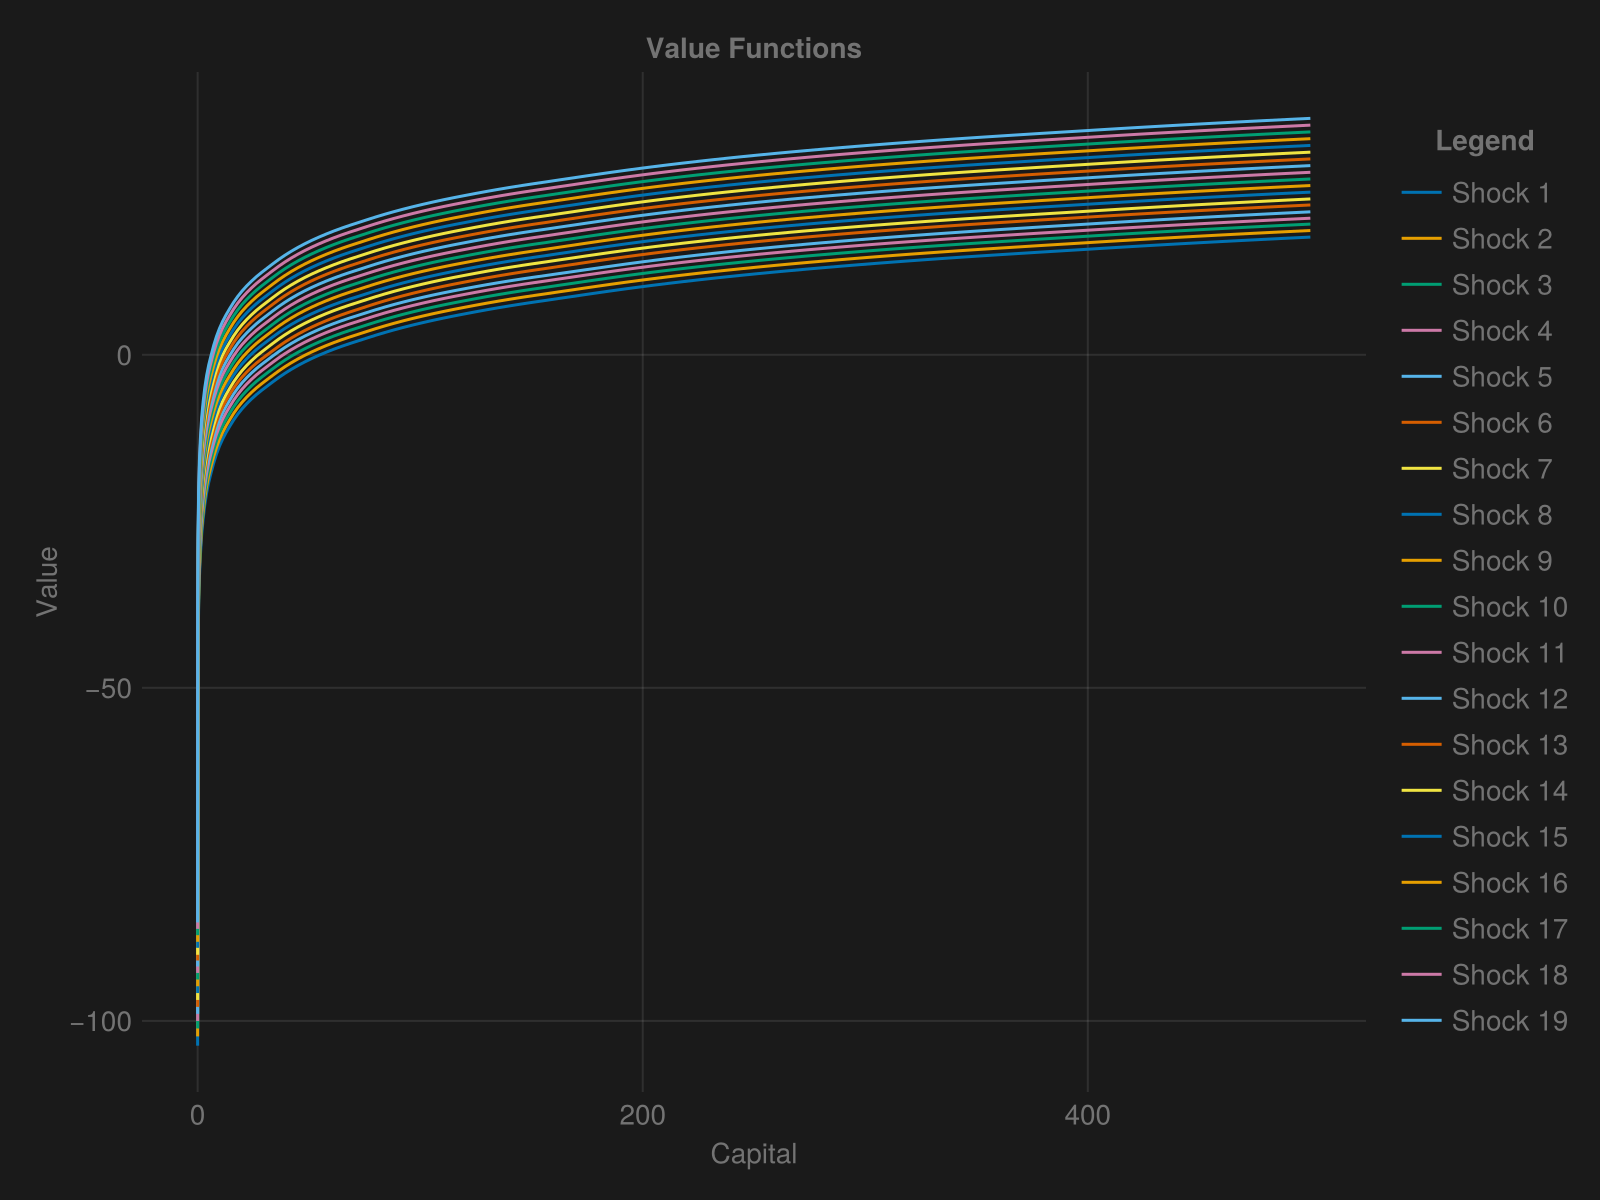

In [136]:
fig1 = Figure(size = (1600, 600))
ax1 = Axis(fig1[1, 1], title = "Capital Policy", xlabel = "Capital Today", ylabel = "Capital Tomorrow")
for j in 1:model_EGM.nz
    lines!(ax1, model_EGM.kgrid, test_s_pol[:,j], label = "Shock $j")
end
lines!(ax1, model_EGM.kgrid, model_EGM.kgrid, label = "45 Deg Line", color = :white, linestyle = :dash)
legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
ax2 = Axis(fig1[1, 3], title = "Consumption Policy", xlabel = "Capital Today", ylabel = "Consumption")
for j in 1:model_EGM.nz
    lines!(ax2, model_EGM.kgrid, test_c_pol_1[:,j], label = "Shock $j")
end
lines!(ax2, model_EGM.kgrid, model_EGM.kgrid, label = "45 Deg Line", color = :white, linestyle = :dash)
legend = Legend(fig1[1,4], ax2, "Legend", orientation = :vertical, fontsize = 4)
display(fig1)

fig2 = Figure(size = (800, 600))
ax2 = Axis(fig2[1, 1], title = "Value Functions", xlabel = "Capital", ylabel = "Value")
for j in 1:model_EGM.nz
    lines!(ax2, model_EGM.kgrid, test_vals[:,j], label = "Shock $j")
end
legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
fig2